# Otimização do processo de transformação das lâminas de alumínio em bobinas para armazenamento e transporte 
   
**Processo**:
- Sensores: variáveis não controladas
- Parâmetros: variáveis controladas (A, B, C, D) 

Caso os parâmetros não sejam ideais, toda a bobina pode ser inutilizada e deverá ser reciclada, o que implica em altos custos de perda de material e de tempo ocioso na fábrica.


**Métricas de avaliação do resultado**
 - Principal métrica: F1
 - Precision (% das vezes que o modelo construído apontou que haveria uma bobina defeituosa e de fato houve)
 - Recall (% das bobinas defeituosas que o modelo conseguiu prever
 
**Outras Perguntas a serem respondidas** 
 - Os parâmetros de controle são capazes de influenciar o resultado? 
 - Qual variável de controle é a mais relevante? E qual variável de sensor? 
 

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score
import imblearn.over_sampling as over
import seaborn as sns
import matplotlib.pyplot as plt
import shap
#!pip install shap

## Importando os dados

Dataset com as nossas features: 

In [2]:
df = pd.read_csv('training_data.csv')
df.head()

,id,control_A,control_B,control_C,control_D,feature_000,feature_001,feature_002,feature_003,feature_004,...,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122
0,41462,204.707993,23.590000,-38.0,-22.0,21000.0,137.699997,23.808040,7.370404,0.766044,...,-16.0,-1.0,3,1,1.0,1,205.501007,23.863001,181.117992,181.638006
1,83053,66.994598,-112.072998,-35.0,-14.0,20900.0,130.800003,29.000000,8.932955,0.660132,...,-21.0,-20.0,4,0,1.0,1,70.575104,-81.214996,179.067596,151.790100
2,83413,53.730701,37.971802,-33.0,-23.0,17100.0,127.300003,27.325832,8.546539,0.438779,...,-10.0,-11.0,4,1,-3.0,-1,47.705799,102.175003,15.758900,-54.469204
3,83950,130.121994,55.860802,-32.0,-8.0,18050.0,127.599998,25.373613,7.980280,0.641993,...,-24.0,-24.0,4,1,1.0,1,121.972000,55.327000,74.261192,66.645000
4,82777,162.807007,-71.336304,-35.0,-3.0,19950.0,290.780173,74.668059,21.470289,0.641987,...,-32.0,-39.0,4,1,1.0,1,160.828003,-41.495602,234.143311,202.323605


Dataset com os targets: 

In [3]:
fail = pd.read_csv('failures.csv')
fail.head()

,id,is_failure
0,81105,0
1,83406,0
2,29471,0
3,84003,0
4,83173,0


In [4]:
fail.is_failure.value_counts()

0    1224
1     102
Name: is_failure, dtype: int64

Como podemos observar, o dataset está bem desbalanceado

Agora, vamos juntar os dois em um único dataframe:

In [5]:
df_complete = pd.merge(df, fail)
df_complete.head()

,id,control_A,control_B,control_C,control_D,feature_000,feature_001,feature_002,feature_003,feature_004,...,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,is_failure
0,41462,204.707993,23.590000,-38.0,-22.0,21000.0,137.699997,23.808040,7.370404,0.766044,...,-1.0,3,1,1.0,1,205.501007,23.863001,181.117992,181.638006,0
1,83053,66.994598,-112.072998,-35.0,-14.0,20900.0,130.800003,29.000000,8.932955,0.660132,...,-20.0,4,0,1.0,1,70.575104,-81.214996,179.067596,151.790100,0
2,83413,53.730701,37.971802,-33.0,-23.0,17100.0,127.300003,27.325832,8.546539,0.438779,...,-11.0,4,1,-3.0,-1,47.705799,102.175003,15.758900,-54.469204,0
3,83950,130.121994,55.860802,-32.0,-8.0,18050.0,127.599998,25.373613,7.980280,0.641993,...,-24.0,4,1,1.0,1,121.972000,55.327000,74.261192,66.645000,0
4,82777,162.807007,-71.336304,-35.0,-3.0,19950.0,290.780173,74.668059,21.470289,0.641987,...,-39.0,4,1,1.0,1,160.828003,-41.495602,234.143311,202.323605,0


## Análise 

<Figure size 648x504 with 0 Axes>

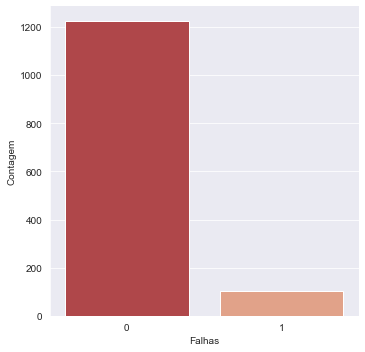

In [6]:
data = df_complete[['id','control_A','control_B','control_C','control_D','is_failure']]

plt.figure(figsize=(9,7))
sns.set_style('darkgrid')
sns.set_palette('RdBu') 
s = sns.catplot(x='is_failure', data=data, kind = 'count')
s.set(xlabel='Falhas', ylabel='Contagem')
plt.show()

Fazendo uma breve análise, constatamos que os dados estão bem desbalanceados. Antes de treinar o modelo, teremos que consertar esse desnivelamento pois isso pode afetar os nossos resultados

#### Pairplot da distribuição total das colunas de controle

<Figure size 864x720 with 0 Axes>

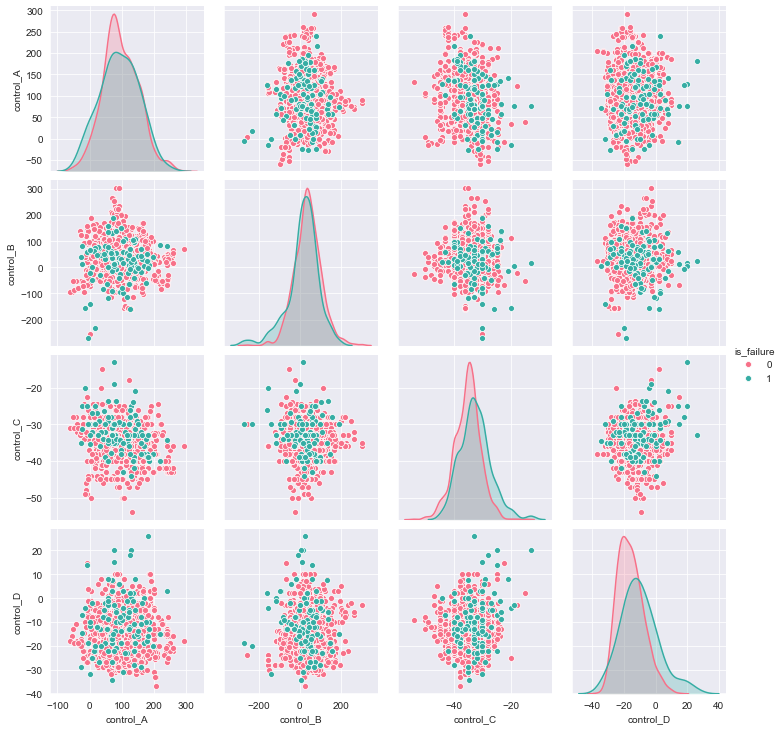

In [7]:
plt.figure(figsize=(12,10))

sns.set_style('darkgrid')
sns.pairplot(data.drop('id', axis=1), hue='is_failure', palette='husl')
plt.show()

## Arrumando os dados
Para consertar os dados desbalanceados, iremos aplicar a técnica de Over Sampling na nossa base de treino 

![title](images/631f484c-fe7a-443f-9119-672d5e6f9e63.jpg)

In [8]:
#selecionando as features e o target 
x = df_complete.drop('is_failure', axis=1)
y = df_complete['is_failure']
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.2, random_state=0)

#Aplicando Over Sampling para a base de treino 
OverSampling = over.SMOTE()
x_resampled_over, y_resampled_over = OverSampling.fit_resample(X_train, Y_train)

## Random Forest

Para o nosso problema, vamos usar o Random Forest Classifier:

In [9]:
model = RandomForestClassifier(random_state=0, n_estimators=100)
model.fit(x_resampled_over, y_resampled_over)

RandomForestClassifier(random_state=0)

## Interpretando os resultados com SHAP

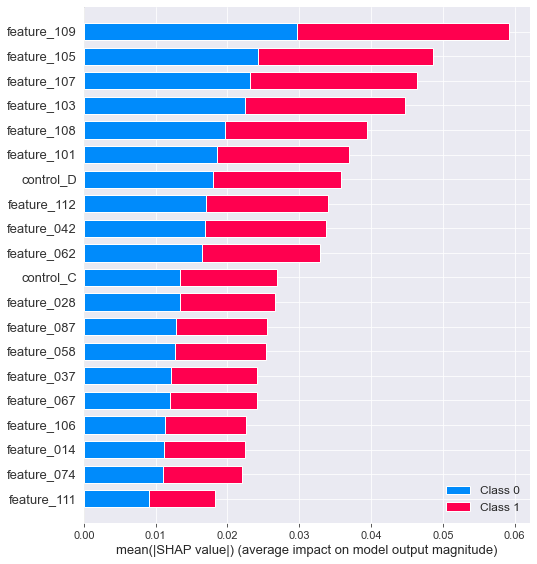

In [15]:
shap.initjs()

#computando os valores shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

In [16]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:], link="logit")

A explicação acima mostra quais features estão contribuindo para mover o output do modelo. As features em vermelho influenciam positivamente, e as em azuis, negativamente. 

Se selecionarmos as explicações e rotacioná-las 90 graus, podemos observar as explicações do dataset inteiro:

In [17]:
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

## Avaliando os resultados
- **Os parâmetros de controle são capazes de influenciar o resultado?**

    Segundo os resultados obtidos com os valores SHAP, os parâmetros de controle C e D podem influenciar o resultado, porém não são as features mais relevantes para o modelo.
    
    
- **Qual variável de controle é a mais relevante? E qual variável de sensor?**
    
    A variável de controle mais relevante é a **D** e a variável de sensor mais relevante é a **feature_109**
    
#### Resultados do F1, precision e recall: 

In [18]:
y_pred = model.predict(X_test)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       248
           1       0.78      0.39      0.52        18

    accuracy                           0.95       266
   macro avg       0.87      0.69      0.75       266
weighted avg       0.95      0.95      0.94       266



## Fazendo as previsões 

In [19]:
new_data = pd.read_csv('new_operational_data.csv')
new_data.head()

,id,control_A,control_B,control_C,control_D,feature_000,feature_001,feature_002,feature_003,feature_004,...,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122
0,2606,135.899994,30.418780,9.320188,0.666373,0.563681,0.493355,-0.237055,8.691623,0.000000,...,68.686001,-23.0,1,1,1,1,1,1,1,1
1,81874,475.456992,89.756979,19.791459,0.597445,0.536668,0.501056,-0.356700,7.490002,0.000000,...,208.076500,-36.0,1,1,1,1,1,1,1,1
2,83831,155.199997,28.500000,8.769473,0.635531,0.521489,0.421350,-0.450412,13.399791,0.916485,...,85.044998,-23.0,1,1,1,1,1,1,1,1
3,81207,146.800003,30.000000,9.092198,1.429990,0.722205,0.624115,-0.082818,18.912727,1.110659,...,288.825699,-23.0,1,1,1,1,1,1,1,1
4,83159,130.300003,28.300003,8.679267,0.750491,0.660402,0.627750,-0.150970,14.768207,0.000000,...,172.457603,-18.0,1,1,1,1,1,1,1,1


In [20]:
pred = model.predict(new_data)
df_pred = pd.DataFrame(pred, columns = ['is_failure'])

In [21]:
df_pred.to_csv('previsoes.csv')

In [24]:
df_pred['is_failure'].value_counts()

1    168
0    164
Name: is_failure, dtype: int64

In [1]:
y_resampled_over.value_counts()

NameError: name 'y_resampled_over' is not defined